In [ ]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, ConfusionMatrixDisplay
pd.options.display.float_format = '{:.5f}'.format
from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV


%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

# **loading data**

In [ ]:
train_data = '/content/drive/MyDrive/UmojaHack Africa 2022: Faulty Air Quality Sensor Challenge/train.csv'
test_data = '/content/drive/MyDrive/UmojaHack Africa 2022: Faulty Air Quality Sensor Challenge/test.csv'

In [ ]:
Train_data = pd.read_csv('/content/drive/MyDrive/UmojaHack Africa 2022: Faulty Air Quality Sensor Challenge/train.csv',  parse_dates = ['Datetime'], low_memory=False,)
Test_data = pd.read_csv('/content/drive/MyDrive/UmojaHack Africa 2022: Faulty Air Quality Sensor Challenge/test.csv', parse_dates = ['Datetime'], low_memory=False,)


# preform data exploration 

In [ ]:
#first 5 index
Train_data.head()

ID            Datetime  Sensor1_PM2.5  Sensor2_PM2.5  \
0  ID_QF0ZTQJ2SF5Q 2021-11-03 04:06:31       52.58000       49.52000   
1  ID_4GTK689CNX5S 2021-11-08 18:43:23       35.25000       33.40000   
2  ID_DL7VVKW9U7XQ 2021-11-07 09:50:33       19.18000       23.50000   
3  ID_6XQOMBXM2DG3 2022-01-01 18:55:15       19.40000       15.48000   
4  ID_UQZW9ISJY9QE 2021-11-05 22:23:48       38.30000       34.77000   

   Temperature  Relative_Humidity  Offset_fault  
0     17.40000           96.00000             0  
1     25.00000           75.00000             0  
2     24.90000           75.00000             0  
3     24.90000           70.00000             0  
4     20.90000           89.00000             0

In [ ]:
# Take a look at our training data
Train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 297177 entries, 0 to 297176
Data columns (total 7 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   ID                 297177 non-null  object        
 1   Datetime           297177 non-null  datetime64[ns]
 2   Sensor1_PM2.5      293563 non-null  float64       
 3   Sensor2_PM2.5      293563 non-null  float64       
 4   Temperature        293628 non-null  float64       
 5   Relative_Humidity  293628 non-null  float64       
 6   Offset_fault       297177 non-null  int64         
dtypes: datetime64[ns](1), float64(4), int64(1), object(1)
memory usage: 15.9+ MB


In [ ]:
Train_data.shape

(297177, 7)

In [ ]:
Train_data.describe()

Sensor1_PM2.5  Sensor2_PM2.5  Temperature  Relative_Humidity  \
count   293563.00000   293563.00000 293628.00000       293628.00000   
mean        40.75120       38.18302     23.31655           78.65362   
std         28.52618       28.64776      3.83697           14.77272   
min         -9.45000       -9.70000     16.70000           27.00000   
25%         22.43000       19.52000     20.40000           68.00000   
50%         36.47000       33.72000     21.90000           84.00000   
75%         49.42000       47.57000     26.30000           91.00000   
max        997.96000      997.26000     34.90000           99.00000   

       Offset_fault  
count  297177.00000  
mean        0.37107  
std         0.48309  
min         0.00000  
25%         0.00000  
50%         0.00000  
75%         1.00000  
max         1.00000

In [ ]:
# plot to see the connection between datatime and Offset_fault
fig, ax = plt.subplots()
ax.scatter(Train_data["Datetime"][:10], Train_data["Offset_fault"][:10])

In [ ]:
#check if we have missing values
Train_data.isna().sum()

ID                      0
Datetime                0
Sensor1_PM2.5        3614
Sensor2_PM2.5        3614
Temperature          3549
Relative_Humidity    3549
Offset_fault            0
dtype: int64

In [ ]:
# Fill numeric rows with the median
for label, content in Train_data.items():
    if pd.api.types.is_numeric_dtype(content):
        if pd.isnull(content).sum():
       
            # Fill missing numeric values with median
            Train_data[label] = content.fillna(content.median())

In [ ]:
# Check for duplicates
Train_data.duplicated().any()

False

In [ ]:
Train_data.Offset_fault.value_counts().plot(kind="bar", color=["salmon", "lightblue"]);

In [ ]:
corr_matrix = Train_data.corr()
plt.figure(figsize=(20.0,10.0))
sns.heatmap(corr_matrix, 
            annot=True, 
            linewidths=0.5, 
            fmt= ".2f", 
            cmap="YlGnBu");

In [ ]:
# take a look at our the important 4 lables 
sub = Train_data[['Sensor1_PM2.5',	'Sensor2_PM2.5',	'Temperature',	'Relative_Humidity']]
sub.head()

Sensor1_PM2.5  Sensor2_PM2.5  Temperature  Relative_Humidity
0       52.58000       49.52000     17.40000           96.00000
1       35.25000       33.40000     25.00000           75.00000
2       19.18000       23.50000     24.90000           75.00000
3       19.40000       15.48000     24.90000           70.00000
4       38.30000       34.77000     20.90000           89.00000

# Checking for outlires 

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f4b090e2910>,
      dtype=object)

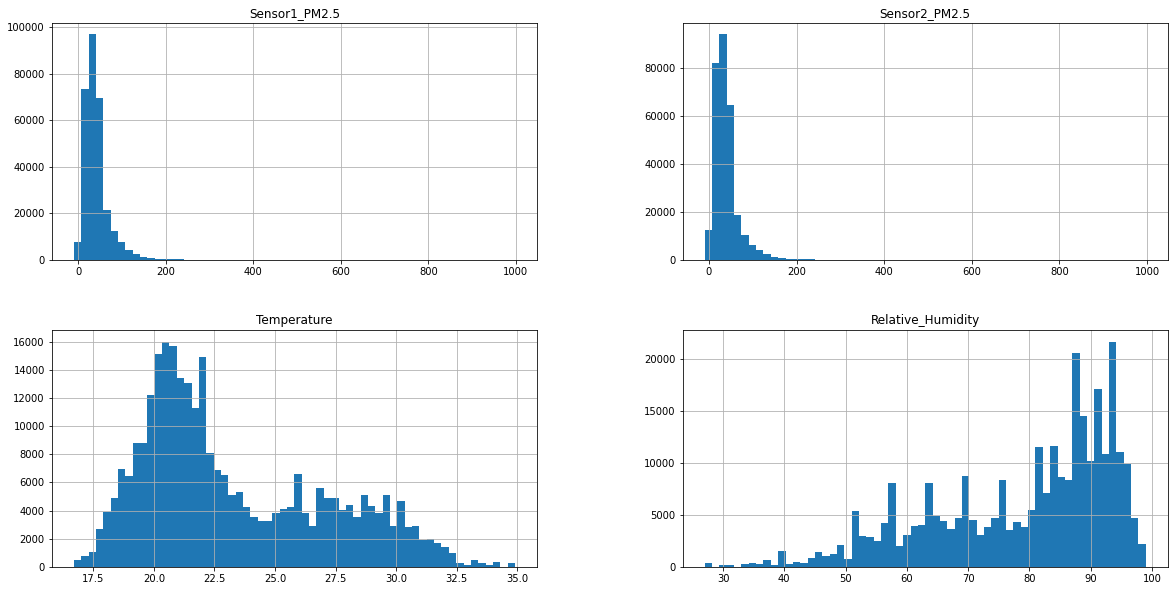

In [ ]:
# checking for outlires in Sensor1_PM2.5 ,Sensor2_PM2.5,	Temperature  and 	Relative_Humidity
sub.hist(bins=60 , figsize=(20 , 10))

In [ ]:
Train_data['Sensor1_PM2.5']

0        52.58000
1        35.25000
2        19.18000
3        19.40000
4        38.30000
           ...   
297172   36.40000
297173   50.12000
297174   53.68000
297175   96.45000
297176   44.27000
Name: Sensor1_PM2.5, Length: 297177, dtype: float64

In [ ]:
#df['Sensor1_PM2.5'].quantile(0.95)


In [ ]:
Train_data[Train_data['Sensor1_PM2.5']>200]

ID            Datetime  Sensor1_PM2.5  Sensor2_PM2.5  \
7509    ID_1NGDVR7ADR4M 2021-10-26 19:43:48      242.27000      233.33000   
11944   ID_MAYKI31TP9UK 2021-11-14 01:05:02      212.22000      202.33000   
13086   ID_QHQKHDP7V0XY 2021-10-24 15:10:09      873.65000      872.95000   
13517   ID_WH773SRN4BTT 2021-10-24 12:33:39      551.38000      550.68000   
14219   ID_W67EBFTI9OQN 2021-10-24 06:47:54      207.70000      197.12000   
...                 ...                 ...            ...            ...   
291185  ID_7P2J5CZWLF5M 2021-10-24 16:50:59      649.62000      648.92000   
291220  ID_21Z904WS1AOV 2021-10-30 00:59:12      203.68000      176.95000   
291954  ID_RMTTIV0UDF5G 2021-10-24 10:15:45      853.81000      853.11000   
295533  ID_LN612Q4IDS1P 2021-10-30 00:46:45      239.82000      208.95000   
296351  ID_X2KYEP4CXC1R 2021-11-24 08:14:18      201.48000      169.13000   

        Temperature  Relative_Humidity  Offset_fault  
7509       23.20000           74.00000             0  
11944      20.20000           81.00000             0  
13086      32.20000           49.00000             0  
13517      31.70000           49.00000             0  
14219      19.70000           92.00000             0  
...             ...                ...           ...  
291185     31.20000           55.00000             0  
291220     20.60000           93.00000             0  
291954     29.50000           57.00000             0  
295533     20.60000           93.00000             0  
296351     18.70000           97.00000             0  

[202 rows x 7 columns]

In [ ]:
Train_data['Sensor1_PM2.5']

0        52.58000
1        35.25000
2        19.18000
3        19.40000
4        38.30000
           ...   
297172   36.40000
297173   50.12000
297174   53.68000
297175   96.45000
297176   44.27000
Name: Sensor1_PM2.5, Length: 297177, dtype: float64

In [ ]:
Train_data[Train_data['Sensor2_PM2.5']>200]

ID            Datetime  Sensor1_PM2.5  Sensor2_PM2.5  \
4342    ID_02Y2YKIMHFSH 2021-12-16 07:34:23      178.25000      209.93000   
7509    ID_1NGDVR7ADR4M 2021-10-26 19:43:48      242.27000      233.33000   
11944   ID_MAYKI31TP9UK 2021-11-14 01:05:02      212.22000      202.33000   
13084   ID_THM1HU7MRWBM 2022-01-05 00:04:31      154.63000      207.33000   
13086   ID_QHQKHDP7V0XY 2021-10-24 15:10:09      873.65000      872.95000   
...                 ...                 ...            ...            ...   
291185  ID_7P2J5CZWLF5M 2021-10-24 16:50:59      649.62000      648.92000   
291954  ID_RMTTIV0UDF5G 2021-10-24 10:15:45      853.81000      853.11000   
294137  ID_J42EHFGM6QT3 2022-01-05 08:19:49      165.95000      203.52000   
295533  ID_LN612Q4IDS1P 2021-10-30 00:46:45      239.82000      208.95000   
296421  ID_O74L48NBNBR9 2022-01-05 08:21:23      176.27000      208.12000   

        Temperature  Relative_Humidity  Offset_fault  
4342       18.60000           92.00000             0  
7509       23.20000           74.00000             0  
11944      20.20000           81.00000             0  
13084      19.30000           81.00000             0  
13086      32.20000           49.00000             0  
...             ...                ...           ...  
291185     31.20000           55.00000             0  
291954     29.50000           57.00000             0  
294137     17.00000           91.00000             0  
295533     20.60000           93.00000             0  
296421     17.00000           91.00000             0  

[222 rows x 7 columns]

In [ ]:
com = Train_data[['Sensor1_PM2.5','Offset_fault' , 'Sensor2_PM2.5']]
com.head()

Sensor1_PM2.5  Offset_fault  Sensor2_PM2.5
0       52.58000             0       49.52000
1       35.25000             0       33.40000
2       19.18000             0       23.50000
3       19.40000             0       15.48000
4       38.30000             0       34.77000

In [ ]:
com1=com[com['Sensor1_PM2.5']>200]


In [ ]:
com1[['Sensor1_PM2.5' , 'Offset_fault']].plot(kind ='scatter' , x ='Offset_fault' , y = 'Sensor1_PM2.5' )

In [ ]:
com2=com[(com['Sensor1_PM2.5']>200) | (com['Sensor2_PM2.5']>200)]
com2

Sensor1_PM2.5  Offset_fault  Sensor2_PM2.5
4342        178.25000             0      209.93000
7509        242.27000             0      233.33000
11944       212.22000             0      202.33000
13084       154.63000             0      207.33000
13086       873.65000             0      872.95000
...               ...           ...            ...
291954      853.81000             0      853.11000
294137      165.95000             0      203.52000
295533      239.82000             0      208.95000
296351      201.48000             0      169.13000
296421      176.27000             0      208.12000

[281 rows x 3 columns]

In [ ]:
min_thr , max_thr = Train_data['Relative_Humidity'].quantile([.50 , 0.95])
min_thr , max_thr

(84.0, 96.0)

In [ ]:
Train_data.describe()

In [ ]:
print(Train_data['Sensor2_PM2.5'].quantile(0.50)) 
print(Train_data['Sensor2_PM2.5'].quantile(0.95)) 
Train_data['Sensor2_PM2.5'] = np.where(Train_data['Sensor2_PM2.5'] > 33.72, 90.82, Train_data['Sensor2_PM2.5'])
Train_data.describe()

In [ ]:
print(Train_data['Temperature'].quantile(0.50)) 
print(Train_data['Temperature'].quantile(0.95)) 
Train_data['Temperature'] = np.where(Train_data['Temperature'] > 21.9, 30.5, Train_data['Temperature'])
Train_data.describe()

In [ ]:
print(Train_data['Relative_Humidity'].quantile(0.50)) 
print(Train_data['Relative_Humidity'].quantile(0.95)) 
Train_data['Relative_Humidity'] = np.where(Train_data['Relative_Humidity'] > 84.0,96.0 , Train_data['Relative_Humidity'])
Train_data.describe()

84.0
96.0


Sensor1_PM2.5  Sensor2_PM2.5  Temperature  Relative_Humidity  \
count   297177.00000   297177.00000 297177.00000       297177.00000   
mean        57.85204       54.90602     25.30761           81.07848   
std         36.44705       36.01963      5.18046           16.56556   
min         -9.45000       -9.70000     16.70000           27.00000   
25%         22.65000       19.70000     20.40000           68.00000   
50%         36.47000       33.72000     21.90000           84.00000   
75%         94.15000       90.82000     30.50000           96.00000   
max         94.15000       90.82000     30.50000           96.00000   

       Offset_fault  
count  297177.00000  
mean        0.37107  
std         0.48309  
min         0.00000  
25%         0.00000  
50%         0.00000  
75%         1.00000  
max         1.00000

In [ ]:
#new =Train_data[(Train_data['Sensor1_PM2.5']<max_thr.fillna().mean()) & (Train_data['Sensor1_PM2.5']>min_thr.fillna().mean())]
#new.shape

AttributeError: ignored

In [ ]:
#min_thr1 , max_thr2 = Train_data['Sensor2_PM2.5'].quantile([0.001 , 0.999])
#min_thr1 , max_thr2

(1.68, 193.43)

In [ ]:
#new =Train_data[(Train_data['Sensor2_PM2.5']<max_thr2.fillna(38.12874)) & (Train_data['Sensor2_PM2.5']>min_thr1.fillna.(38.12874))]
#new.shape

(296579, 10)

In [ ]:
#min_thr3 , max_thr3 = Train_data['Temperature'].quantile([0.001 , 0.999])
#min_thr3 , max_thr3

(17.0, 34.0)

In [ ]:
#new =Train_data[(Train_data['Sensor2_PM2.5']<max_thr3.fillna.(23.29964)) & (Train_data['Sensor2_PM2.5']>min_thr3.fillna.(23.29964))]
#new.shape

(91574, 10)

In [ ]:
#min_thr4 , max_thr4 = Train_data['Relative_Humidity'].quantile([0.001 , 0.999])
#min_thr4 , max_thr4

(27.0, 99.0)

In [ ]:
#new =Train_data[(Train_data['Relative_Humidity']<max_thr4.fillna.(78.71747)) & (Train_data['Relative_Humidity']>min_thr4.fillna.(78.71747))]
#new.shape

(296143, 10)

In [ ]:
#new3.sample(10)

ID  Sensor1_PM2.5  Sensor2_PM2.5  Temperature  \
113989  ID_7G8F7CXV25Y4       45.75000       50.13000     19.50000   
78912   ID_9XU8JL1INQF1       52.13000       49.53000     21.70000   
150605  ID_GP5ATZWAPC08        7.47000        8.57000     27.90000   
276013  ID_2FOV73OAHKT3       25.27000       31.28000     20.30000   
59079   ID_R8G552E2TOR2       21.20000       15.28000     21.60000   
195554  ID_EN54DO0XZWW1        7.25000       11.80000     29.70000   
152571  ID_L172HJR5L124       36.22000       32.52000     21.10000   
62977   ID_EQ4NB2V0ZHM5       46.85000       48.00000     24.50000   
125722  ID_6AAPP2GVW8R7       40.72000       37.53000     19.60000   
168953  ID_32O08XEX65XC       42.87000       47.38000     20.00000   

        Relative_Humidity  Offset_fault  Year  Month  Day  Hours  
113989           67.00000             0  2022      1   21      4  
78912            88.00000             0  2021     12    1     23  
150605           68.00000             0  2021     12   29     13  
276013           84.00000             0  2022      1   17      2  
59079            90.00000             1  2022      1   11     23  
195554           58.00000             0  2021     12    6     15  
152571           92.00000             1  2022      1   12      2  
62977            70.00000             0  2021     10   27     19  
125722           96.00000             0  2021     11    6      7  
168953           92.00000             0  2021     11   26     23

# Data cleaning 

In [ ]:
Train_data.sort_values(by=["Datetime"], inplace=True, ascending=True)
Train_data.Datetime.head(20)

116880   2021-10-15 16:00:31
220210   2021-10-15 16:00:34
260869   2021-10-15 16:01:01
200775   2021-10-15 16:01:54
164575   2021-10-15 16:02:06
7572     2021-10-15 16:02:13
255867   2021-10-15 16:03:18
242989   2021-10-15 16:03:26
252121   2021-10-15 16:03:37
239020   2021-10-15 16:04:42
62539    2021-10-15 16:05:08
266633   2021-10-15 16:06:04
49743    2021-10-15 16:06:40
220721   2021-10-15 16:07:27
134964   2021-10-15 16:07:47
241097   2021-10-15 16:08:12
62591    2021-10-15 16:08:50
139620   2021-10-15 16:09:00
193611   2021-10-15 16:09:46
97879    2021-10-15 16:10:13
Name: Datetime, dtype: datetime64[ns]

In [ ]:
#create new columns for  year , month , day and hours
Train_data["Year"] = Train_data.Datetime.dt.year
Train_data["Month"] = Train_data.Datetime.dt.month
Train_data["Day"] = Train_data.Datetime.dt.day
Train_data["Hours"] = Train_data.Datetime.dt.hour


In [ ]:
Train_data.head()

ID            Datetime  Sensor1_PM2.5  Sensor2_PM2.5  \
116880  ID_37STUCVVPZKP 2021-10-15 16:00:31        9.17000        9.28000   
220210  ID_YZZUOMF0TQIF 2021-10-15 16:00:34        9.93000       11.25000   
260869  ID_UF68QLIPG3LE 2021-10-15 16:01:01        6.53000        3.15000   
200775  ID_KKCO4VATOSWB 2021-10-15 16:01:54        8.30000        8.35000   
164575  ID_8YNKABZP11SS 2021-10-15 16:02:06        6.87000        9.57000   

        Temperature  Relative_Humidity  Offset_fault  Year  Month  Day  Hours  
116880     30.50000           53.00000             0  2021     10   15     16  
220210     30.50000           53.00000             0  2021     10   15     16  
260869     30.50000           53.00000             1  2021     10   15     16  
200775     30.50000           53.00000             0  2021     10   15     16  
164575     30.50000           53.00000             0  2021     10   15     16

In [ ]:
# Now we've enriched our DataFrame with date time features, we can remove 'Datetime'
Train_data.drop("Datetime", axis=1, inplace=True)


In [ ]:
Train_data.head()

ID  Sensor1_PM2.5  Sensor2_PM2.5  Temperature  \
116880  ID_37STUCVVPZKP        9.17000        9.28000     30.50000   
220210  ID_YZZUOMF0TQIF        9.93000       11.25000     30.50000   
260869  ID_UF68QLIPG3LE        6.53000        3.15000     30.50000   
200775  ID_KKCO4VATOSWB        8.30000        8.35000     30.50000   
164575  ID_8YNKABZP11SS        6.87000        9.57000     30.50000   

        Relative_Humidity  Offset_fault  Year  Month  Day  Hours  
116880           53.00000             0  2021     10   15     16  
220210           53.00000             0  2021     10   15     16  
260869           53.00000             1  2021     10   15     16  
200775           53.00000             0  2021     10   15     16  
164575           53.00000             0  2021     10   15     16

In [ ]:
Test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 127361 entries, 0 to 127360
Data columns (total 6 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   ID                 127361 non-null  object        
 1   Datetime           127361 non-null  datetime64[ns]
 2   Sensor1_PM2.5      127361 non-null  float64       
 3   Sensor2_PM2.5      127361 non-null  float64       
 4   Temperature        39271 non-null   float64       
 5   Relative_Humidity  39271 non-null   float64       
dtypes: datetime64[ns](1), float64(4), object(1)
memory usage: 5.8+ MB


In [ ]:
Test_data.isna().sum()

ID                       0
Datetime                 0
Sensor1_PM2.5            0
Sensor2_PM2.5            0
Temperature          88090
Relative_Humidity    88090
dtype: int64

In [ ]:
# Fill numeric rows with the median
for label, content in Test_data.items():
    if pd.api.types.is_numeric_dtype(content):
        if pd.isnull(content).sum():
       
            # Fill missing numeric values with median
            Test_data[label] = content.fillna(content.median())

In [ ]:
Test_data.isna().sum()

ID                   0
Datetime             0
Sensor1_PM2.5        0
Sensor2_PM2.5        0
Temperature          0
Relative_Humidity    0
dtype: int64

In [ ]:
# we do the same here for our test data 
Test_data["Year"] = Test_data.Datetime.dt.year
Test_data["Month"] = Test_data.Datetime.dt.month
Test_data["Day"] = Test_data.Datetime.dt.day
Test_data["Hours"] = Test_data.Datetime.dt.hour

In [ ]:
Test_data.head()

ID            Datetime  Sensor1_PM2.5  Sensor2_PM2.5  \
0  ID_STL3V9B2OU12 2022-01-28 08:49:41       90.75000      114.78000   
1  ID_U2EKAY4SGA94 2022-02-16 21:30:17       56.03000       52.18000   
2  ID_UJFLEWQR0U4N 2022-01-24 17:57:18      387.35000      346.73000   
3  ID_S2C2GPGA4R5I 2022-01-31 07:07:09       63.17000       83.85000   
4  ID_5V2C2ZL221H8 2022-01-31 00:37:05       69.23000       53.07000   

   Temperature  Relative_Humidity  Year  Month  Day  Hours  
0     22.20000           56.00000  2022      1   28      8  
1     22.50000           78.00000  2022      2   16     21  
2     28.10000           63.00000  2022      1   24     17  
3     21.60000           82.00000  2022      1   31      7  
4     22.70000           80.00000  2022      1   31      0

In [ ]:
# Now we've enriched our DataFrame with date time features, we can remove 'Datetime'
Test_data.drop("Datetime", axis=1, inplace=True)


In [ ]:
Test_data.head()

ID  Sensor1_PM2.5  Sensor2_PM2.5  Temperature  \
0  ID_STL3V9B2OU12       90.75000      114.78000     22.20000   
1  ID_U2EKAY4SGA94       56.03000       52.18000     22.50000   
2  ID_UJFLEWQR0U4N      387.35000      346.73000     28.10000   
3  ID_S2C2GPGA4R5I       63.17000       83.85000     21.60000   
4  ID_5V2C2ZL221H8       69.23000       53.07000     22.70000   

   Relative_Humidity  Year  Month  Day  Hours  
0           56.00000  2022      1   28      8  
1           78.00000  2022      2   16     21  
2           63.00000  2022      1   24     17  
3           82.00000  2022      1   31      7  
4           80.00000  2022      1   31      0

#Modelling


In [ ]:
#using Xgboost to train our model 
%%time


 
model = XGBClassifier()
model.fit(Train_data.drop(["ID" , "Offset_fault"], axis=1 ), Train_data["Offset_fault"])



CPU times: user 16.6 s, sys: 86.1 ms, total: 16.7 s
Wall time: 20.8 s


In [ ]:
model.score(Train_data.drop(["ID" , "Offset_fault"], axis=1 ), Train_data["Offset_fault"])

0.8373326334137567

In [ ]:
# set our x and y 
x = Train_data.drop(["ID" , "Offset_fault"], axis=1 )
y = Train_data["Offset_fault"]

In [ ]:
# Splitting the data into training and testing sets

from sklearn.model_selection import train_test_split

X_train, X_test, y_train,y_test=train_test_split(x,y,train_size=0.70,random_state=123)

In [ ]:
from sklearn.metrics import mean_squared_log_error , mean_absolute_error

In [ ]:
#show score on the training data
def show_scores(model):
    train_preds = model.predict(X_train)
    scores = {"Training MAE": mean_absolute_error(y_train, train_preds),}
    return scores
  

In [ ]:
show_scores(model)

{'Training MAE': 0.16230897544983006}

In [ ]:
#make a list of parameters to tune using GridSearchCV

param_grid = { 'learning_rate' : [0.05,0.10,0.15,0.20,0.25,0.30],
               'max_depth' : [ 3, 4, 5, 6, 8, 10, 12, 15],
               'min_child_weight' : [ 1, 3, 5, 7 ],
               'n_iter' : [5,10,20,30,50],
               'gamma': [ 0.0, 0.1, 0.2 , 0.3, 0.4 ],
               'colsample_bytree' : [ 0.3, 0.4, 0.5 , 0.7 ]
         } 
    

In [ ]:
clf = RandomizedSearchCV(model,param_distributions=param_grid,scoring='roc_auc',n_jobs=-1,cv=5,verbose=3)

# train the random search meta-estimator to find the best model out of 100 candidates
model = clf.fit(x, y)

# print winning set of hyperparameters
from pprint import pprint
pprint(model.best_estimator_.get_params())

Fitting 5 folds for each of 10 candidates, totalling 50 fits
{'base_score': 0.5,
 'booster': 'gbtree',
 'colsample_bylevel': 1,
 'colsample_bynode': 1,
 'colsample_bytree': 0.7,
 'gamma': 0.2,
 'learning_rate': 0.1,
 'max_delta_step': 0,
 'max_depth': 3,
 'min_child_weight': 5,
 'missing': None,
 'n_estimators': 100,
 'n_iter': 20,
 'n_jobs': 1,
 'nthread': None,
 'objective': 'binary:logistic',
 'random_state': 0,
 'reg_alpha': 0,
 'reg_lambda': 1,
 'scale_pos_weight': 1,
 'seed': None,
 'silent': None,
 'subsample': 1,
 'verbosity': 1}


In [ ]:
# our final best parameters
clf.best_params_

{'colsample_bytree': 0.7,
 'gamma': 0.2,
 'learning_rate': 0.1,
 'max_depth': 3,
 'min_child_weight': 5,
 'n_iter': 20}

In [ ]:
show_scores(clf)

{'Training MAE': 0.1636790162626248}

Make predection on the X_test

In [ ]:
y_pred = clf.predict(X_test)

In [ ]:
print(f'Accuracy score: {accuracy_score(y_test, y_pred)}')

Accuracy score: 0.8344325549049959


# Make predection on the Test data

In [ ]:

Test = Test_data.drop(['ID'], axis=1)

In [ ]:
Test.head()

Sensor1_PM2.5  Sensor2_PM2.5  Temperature  Relative_Humidity  Year  Month  \
0       90.75000      114.78000     22.20000           56.00000  2022      1   
1       56.03000       52.18000     22.50000           78.00000  2022      2   
2      387.35000      346.73000     28.10000           63.00000  2022      1   
3       63.17000       83.85000     21.60000           82.00000  2022      1   
4       69.23000       53.07000     22.70000           80.00000  2022      1   

   Day  Hours  
0   28      8  
1   16     21  
2   24     17  
3   31      7  
4   31      0

In [ ]:
Test_preds = clf.predict(Test)

In [ ]:
Train_data.head()

ID  Sensor1_PM2.5  Sensor2_PM2.5  Temperature  \
116880  ID_37STUCVVPZKP        9.17000        9.28000     30.50000   
220210  ID_YZZUOMF0TQIF        9.93000       11.25000     30.50000   
260869  ID_UF68QLIPG3LE        6.53000        3.15000     30.50000   
200775  ID_KKCO4VATOSWB        8.30000        8.35000     30.50000   
164575  ID_8YNKABZP11SS        6.87000        9.57000     30.50000   

        Relative_Humidity  Offset_fault  Year  Month  Day  Hours  
116880           53.00000             0  2021     10   15     16  
220210           53.00000             0  2021     10   15     16  
260869           53.00000             1  2021     10   15     16  
200775           53.00000             0  2021     10   15     16  
164575           53.00000             0  2021     10   15     16

# Making our Submission File 

In [ ]:
S_file = pd.DataFrame()
S_file["ID"] = Test_data["ID"]
S_file["Offset_fault"] = Test_preds
S_file

ID  Offset_fault
0       ID_STL3V9B2OU12             0
1       ID_U2EKAY4SGA94             0
2       ID_UJFLEWQR0U4N             0
3       ID_S2C2GPGA4R5I             0
4       ID_5V2C2ZL221H8             1
...                 ...           ...
127356  ID_HNCS9Q2GNCQB             0
127357  ID_GIIQYTE11L3H             1
127358  ID_EC7F1P4GXKCL             0
127359  ID_J64RVG2BRAG0             0
127360  ID_7ABZNHCIVVAV             0

[127361 rows x 2 columns]

In [ ]:
#uploading our Submission File to my google drive account 
S_file.to_csv(r'/content/drive/MyDrive/test_predections_17.csv', index = False)